# Projeto B - Previsão de Faturamento

<sub>Projeto para a disciplina de **Estatística** (Módulo 4) do Data Science Degree (turma de julho de 2020)</sub>

## Equipe

* Felipe Lima de Oliveira
* Mário Henrique Romagna Cesa
* Tsuyioshi Valentim Fukuda
* Fernando Raineri Monari

Link para [projeto no Github](https://github.com/flimao/case-previsao-faturamento)

## Introdução

Este notebook contém a análise exploratória inicial dos dados.

In [1]:
# importação de bibliotecas
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json

# importação de bibliotecas de análise
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from pmdarima.arima import auto_arima

# teste para verificar estacionariedade (Dickey-Fuller: https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test)
from statsmodels.tsa.stattools import adfuller

# metricas 
from sklearn.metrics import mean_absolute_percentage_error as smape, mean_squared_error as smse, mean_absolute_error as smae 

# pacote com funções para análise desse projeto
import os
cwd = os.getcwd()
os.chdir("../")
import py_scripts.plots, py_scripts.transform
os.chdir(cwd)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = (10, 4)

## Importação dos dados e análise inicial

Inicialmente, vamos importar e ver a aparência geral dos dados:

* número e nome de colunas
* qual o tipo de dados de cada coluna
* Algumas linhas do dataset

In [2]:
# importar base e iniciar a análise inicial
ts_raw = pd.read_csv(r'../data/sim_ts.txt', sep = '\t')
ts_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   vlr      511 non-null    float64
 1   date     511 non-null    object 
 2   produto  511 non-null    object 
dtypes: float64(1), object(2)
memory usage: 12.1+ KB


In [3]:
ts_raw.describe()

,vlr
count,5.110000e+02
mean,4.187929e+08
std,6.272376e+08
min,0.000000e+00
25%,6.472878e+05
50%,2.261791e+07
75%,1.028848e+09
max,1.990000e+09


In [4]:
ts_raw.sample(5).sort_index()

,vlr,date,produto
20,1.040682e+09,2011-08-01,alimenticio
58,1.268744e+09,2014-10-01,alimenticio
160,1.613588e+08,2016-06-01,transporte
294,1.241609e+06,2015-09-01,auxilio_final_de_ano
398,9.651207e+04,2016-02-01,bonificacao


### Limpeza dos dados

Vamos definir algumas funções de limpeza dos dados.

Ao final desse processo, teremos três estruturas de dados:

- um *dataframe* `ts` associando os meses aos faturamentos e aos produtos;
- um dicionário `tsd` cujas chaves serão os produtos e os valores serão *Series* associando meses e faturamentos (contanto desde o lançamento do produto); e
- um *dataframe* `tswide` onde cada coluna corresponde à série histórica de um produto.

Ao dicionário `tsd` será adicionada uma chave, `total`, contendo a soma dos faturamentos de todos os produtos mês a mês.

In [5]:
# limpeza 1: conversão de tipos

def conversao_tipos(df):
    df = df.copy()

    df['date'] = df['date'].astype('datetime64[ns]')
    df['produto'] = df['produto'].astype('category')
    return df

# limpeza 2: setar a coluna de data como indice
def setar_indice_data(df):
    df = df.copy()

    s = df.set_index('date')['vlr']

    return s

# limpeza 3: gerar dados de meses faltantes

def gerar_dados_faltantes(s):
    s = s.copy()

    s = s.asfreq('MS')

    return s

# limpeza 4: preencher missings
def preencher_missings(s):
    s = s.copy()

    # s = s.interpolate()

    return s

# executar limpeza para o DF ts
# não é possível setar a data como índice porque há multiplas entradas com mesmo mês.
# isso geraria problemas para funções de agregação (groupby's etc) e JOIN's.
# logo, para o 
ts = (ts_raw
    .pipe(conversao_tipos)
)


In [6]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   vlr      511 non-null    float64       
 1   date     511 non-null    datetime64[ns]
 2   produto  511 non-null    category      
dtypes: category(1), datetime64[ns](1), float64(1)
memory usage: 8.8 KB


In [7]:
ts.sample(10).sort_index()

,vlr,date,produto
17,1.028409e+09,2011-05-01,alimenticio
42,1.122137e+09,2013-06-01,alimenticio
205,1.845871e+08,2020-03-01,transporte
229,5.390574e+05,2010-04-01,auxilio_final_de_ano
314,5.102712e+05,2017-05-01,auxilio_final_de_ano
376,1.270131e+05,2013-12-01,bonificacao
423,1.602181e+05,2018-08-01,bonificacao
438,1.575599e+05,2020-03-01,bonificacao
452,5.594537e+06,2016-12-01,saude
463,1.700685e+07,2017-11-01,saude


Vamos agora construir o dicionário `tsd` e o dataframe `tswide`:

In [8]:
produtos = ts['produto'].cat.categories

tsd = {}
for produto in produtos:
    ts_produto = ts[ts['produto'] == produto]

    # finalizar limpeza para Series dentro do dicionário
    s_prod = (ts_produto
        .pipe(setar_indice_data)
        .pipe(gerar_dados_faltantes)
        .pipe(preencher_missings)
    )
    s_prod.name = f'faturamento_{produto}'
    tsd[produto] = s_prod

tswide = pd.DataFrame(tsd)

sprodtotal = tswide.sum(axis = 1)
sprodtotal.name = 'faturamento_total'
tsd['total'] = sprodtotal

for produto, s in tsd.items():
    print(f"Quantidade de dados faltantes para o produto '{produto}': {s.isna().sum()}")
    print(f"Lançamento do produto '{produto}': {s.index[0].strftime('%Y-%m-%d')}")
    print('')

# confirmação do dataframe limpo
# ts.info()

Quantidade de dados faltantes para o produto 'alimenticio': 0
Lançamento do produto 'alimenticio': 2009-12-01

Quantidade de dados faltantes para o produto 'auxilio_final_de_ano': 0
Lançamento do produto 'auxilio_final_de_ano': 2009-12-01

Quantidade de dados faltantes para o produto 'bonificacao': 30
Lançamento do produto 'bonificacao': 2012-01-01

Quantidade de dados faltantes para o produto 'saude': 0
Lançamento do produto 'saude': 2016-11-01

Quantidade de dados faltantes para o produto 'transporte': 0
Lançamento do produto 'transporte': 2015-01-01

Quantidade de dados faltantes para o produto 'total': 0
Lançamento do produto 'total': 2009-12-01



#### Tratamento de valores faltantes

Há alguns padrões interessantes de valores faltantes para alguns produtos:

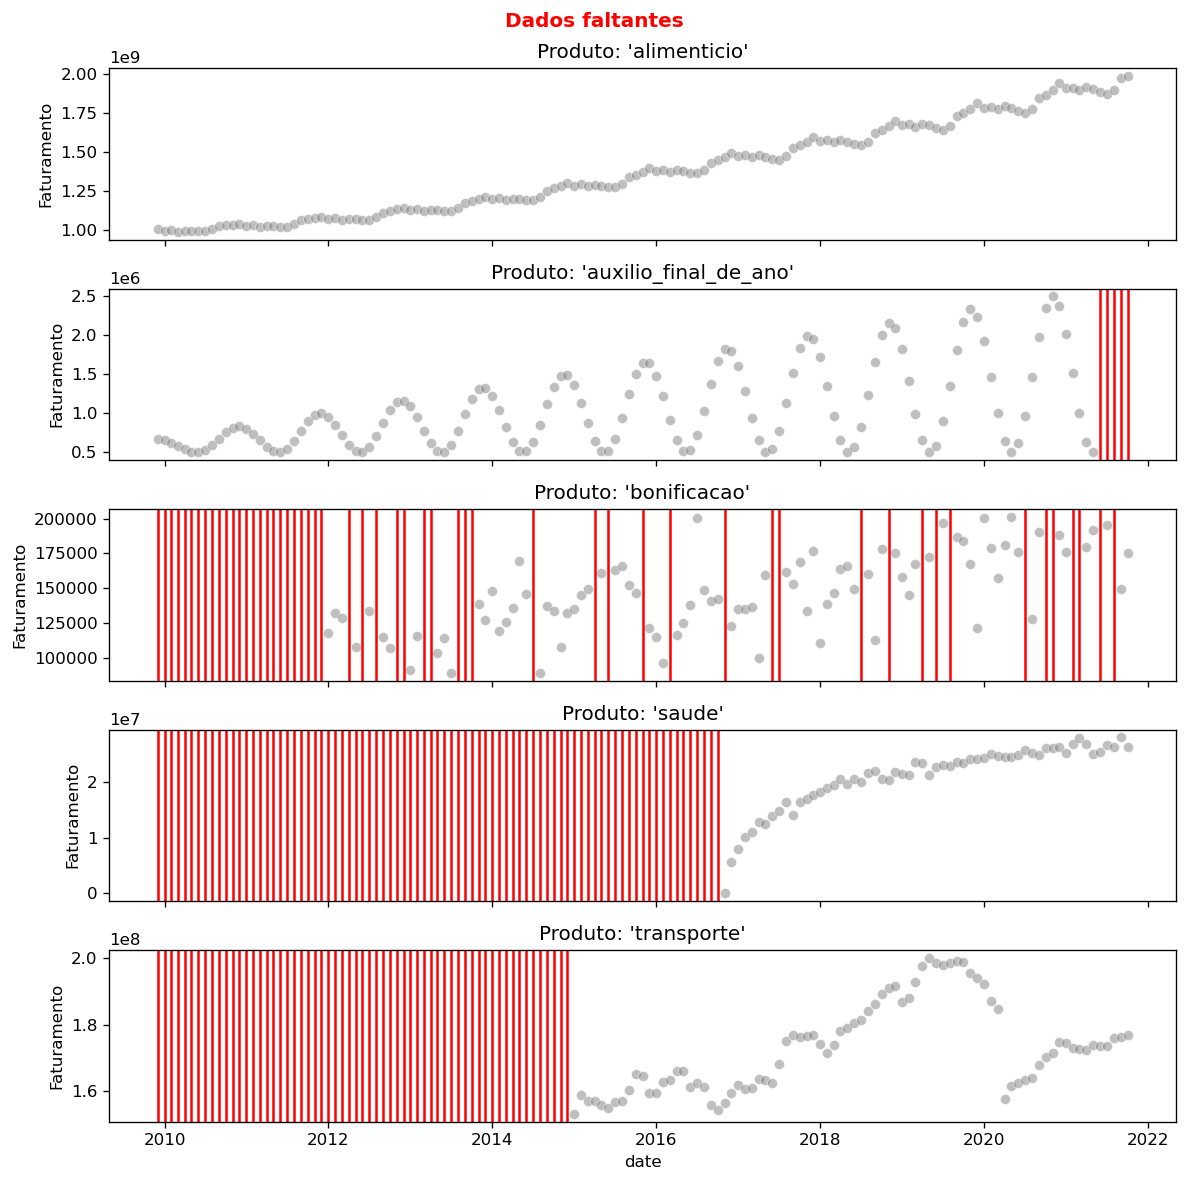

In [9]:
py_scripts.plots.dados_faltantes(tswide)

In [10]:
tswide.index[tswide['auxilio_final_de_ano'].isna()]

DatetimeIndex(['2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01',
               '2021-10-01'],
              dtype='datetime64[ns]', name='date', freq='MS')

Claramente, vê-se que:

- **Não há nenhum dado faltante para o produto `alimenticio`**;
- Os produtos `saude` e `transporte` foram introduzidos após o início da série histórica. **Não há nenhum dado faltante após o lançamento desses produtos**.
- O produto `auxilio_final_de_ano` tem dados faltantes seguidos após maio de 2021. É razoável assumir que há uma falha na coleta de dados nos últimos 5 meses. **Deixaremos estes valores indefinidos por enquanto, de forma a facilitar a análise de séries temporais que seguirá**. 
- O produto `bonificacao` também foi introduzido após o início da série histórica; no entanto, contém dados faltantes aparentemente de forma aleatória.

Logo, devemos avaliar o que faremos a respeito dos dados faltantes do produto `bonificacao`.

Nota-se no gráfico acima que o produto `bonificacao` responde por um faturamento 4 ordens de magnitude menor que o produto `alimenticio`. Independente do tratamento a ser dado, o efeito sobre o faturamento total será mínimo.

No entanto, uma das funcionalidades dos modelos de séries temporais que usaremos é a **imputação de valores faltantes**. Por conta disso, vamos deixar os valores da série `bonificacao` indefinidos, de forma que possam ser imputados com seus valores mais prováveis em um moento posterior.

In [11]:
# OBS: antes do lançamento, o faturamento deve ser nan. 
# Isso auxiliará na dropagem de valores antes do lançamento depois
# Caso queiramos a série completa (incluindo os nan), basta acessarmos
# o DF `tswide`

# construindo um dicionario com a data de lancamento de cada produto
# primeira data com dados não nulos
lancamentos = { }

for produto in produtos:
    s = tsd[produto]
    lancamento = s.index[0]
    lancamentos[produto] = lancamento

# bonificacao: valores faltantes após lançamento do produto são 0
#tswide['bonificacao'] = tswide['bonificacao'].fillna(0)
tswide.loc[:lancamentos['bonificacao'], 'bonificacao'] = np.nan

# auxilio_fim_de_ano: valores faltantes em 2021 são 0 (produto descontinuado)
#tswide['auxilio_final_de_ano'] = tswide['auxilio_final_de_ano'].fillna(0)
tswide.loc[:lancamentos['auxilio_final_de_ano'], 'auxilio_final_de_ano'] = np.nan

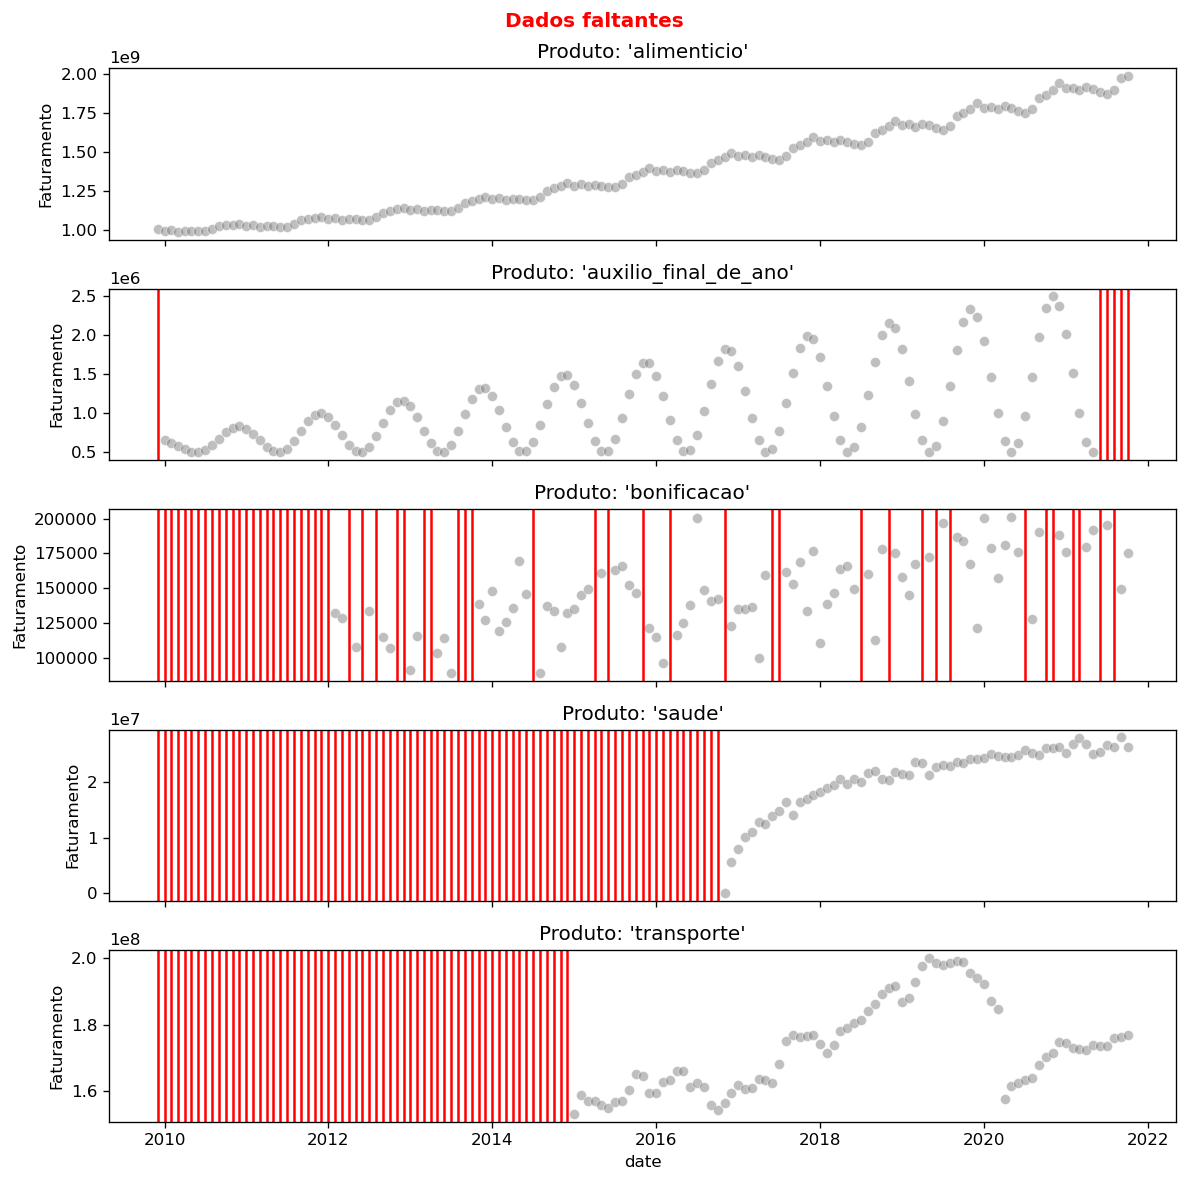

In [12]:
py_scripts.plots.dados_faltantes(tswide)

Vamos agora reconstruir o dicionário `tsd` após completar os valores faltantes.

In [13]:
tsd = {}
for produto in produtos:
    sprod = tswide[produto].dropna()
    sprod.name = f'faturamento_{produto}'
    tsd[produto] = sprod

sprodtotal = tswide.sum(axis = 'columns')
tsd['total'] = sprodtotal

Por fim, vamos salvar os dados limpos e pré-processados.

In [14]:
sim_ts = py_scripts.transform.wide2long(tswide)

# salvar
sim_ts.to_csv(r'../data/sim_ts_limpo.csv', index = False)

### Análise exploratória - Faturamento total

A análise da série temporal do faturamento total está contida em [notebook próprio (`2-faturamento_total.ipynb`)](./2-faturamento_total.ipynb).

### Análise exploratória dos dados - Segregado por produto

Primeiramente vamos fazer uma análise das medidas descritivas dos dados completos.

In [14]:
tswide.describe()

,alimenticio,auxilio_final_de_ano,bonificacao,saude,transporte
count,1.430000e+02,1.420000e+02,117.000000,6.000000e+01,8.200000e+01
mean,1.387476e+09,1.023809e+06,109090.976536,2.089162e+07,1.729469e+08
std,2.965446e+08,5.517009e+05,68895.397270,5.826385e+06,1.340913e+07
min,9.900000e+08,0.000000e+00,0.000000,0.000000e+00,1.532707e+08
25%,1.122228e+09,6.029612e+05,0.000000,1.868296e+07,1.616310e+08
50%,1.364441e+09,8.884030e+05,133658.856529,2.275080e+07,1.726690e+08
75%,1.644394e+09,1.358786e+06,160731.244724,2.502346e+07,1.812734e+08
max,1.990000e+09,2.500000e+06,201331.273286,2.800000e+07,2.000000e+08


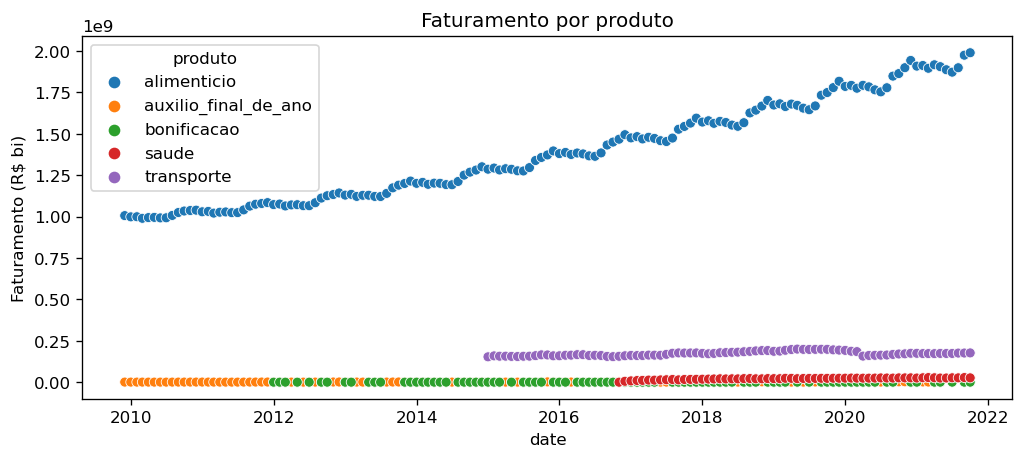

In [15]:
fig = plt.figure()
sns.scatterplot(data = ts, x = 'date', y = 'vlr', hue = 'produto') 
plt.ylabel('Faturamento (R$ bi)')
plt.title('Faturamento por produto')
plt.show()

Claramente os valores auferidos em cada produto tem ordens de grandeza totalmente diferentes. Por conta disso, não conseguimos enxergar as tendências dos produtos com valores que tem ordens de grandeza menores.

Melhor fazer um gráfico para cada produto, com escalas diferentes para os valores.

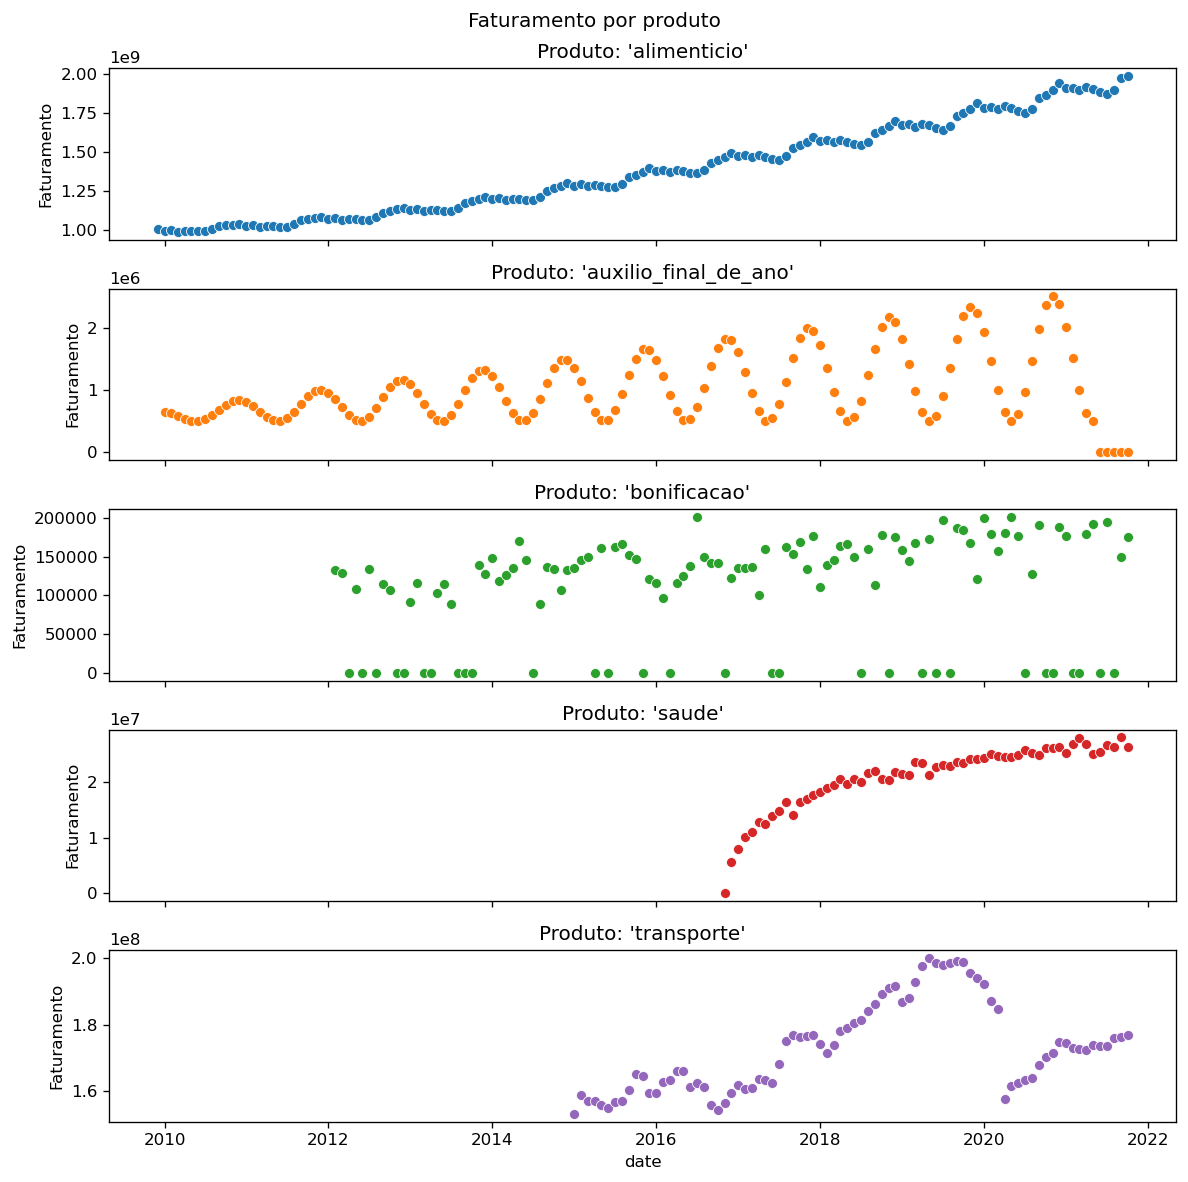

In [16]:
n_produtos = len(produtos)

palette = sns.color_palette(None, n_produtos)

fig, axs = plt.subplots(nrows = n_produtos, ncols = 1, sharex = True, figsize = (10, 10))

for i, produto in enumerate(produtos):
    ax = axs[i]
    sns.scatterplot(data = tsd[produto], ax = ax, color = palette[i])
    ax.set_title(f"Produto: '{produto}'")
    ax.set_ylabel('Faturamento')

fig.suptitle('Faturamento por produto')
plt.tight_layout()
plt.show()


### Análise exploratória - Produto `alimenticio`

A análise da série temporal do faturamento total está contida em [notebook próprio (`3-produto_alimenticio.ipynb`)](./3-produto_alimenticio.ipynb).

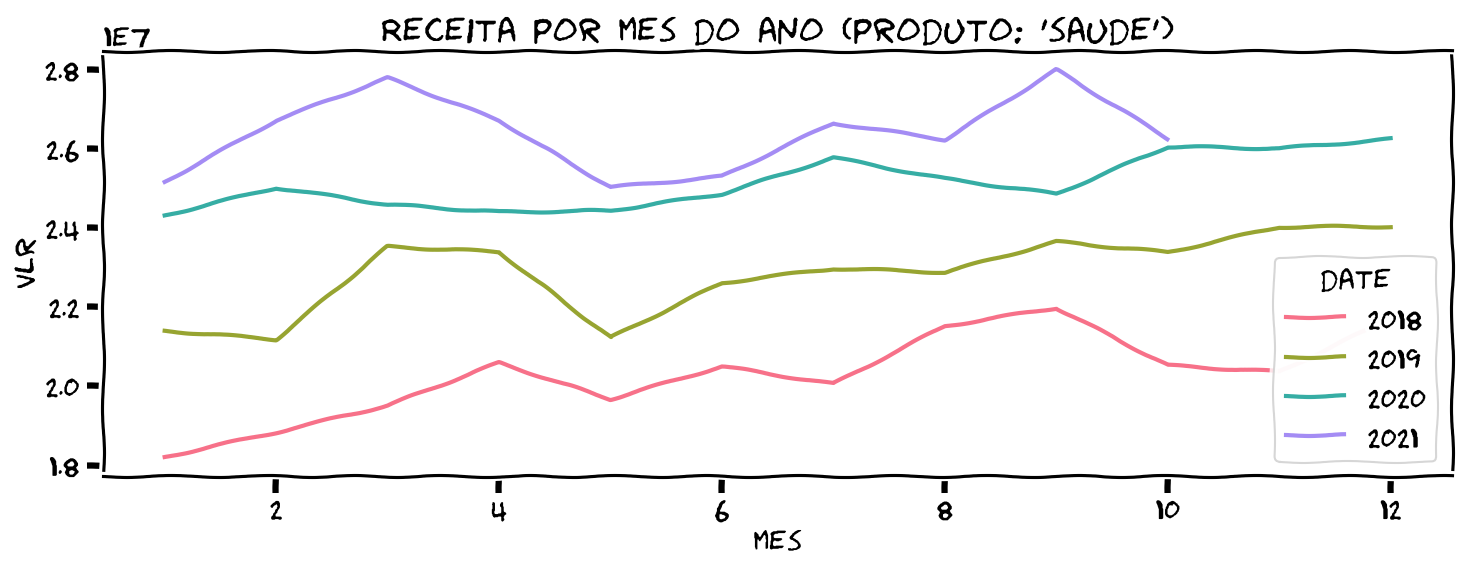

In [10]:
produto = 'saude'
df = ts[(ts.produto == produto) & ((ts.index >= '2018-01-01') | (ts.index >= '2021-12-01'))]
hue = df.index.year
x = df.index.month

with plt.xkcd():
    ax = sns.lineplot(data = df, y = 'vlr', x = x, hue = hue, palette = sns.color_palette('husl', hue.unique().shape[0]))
    ax.set_xlabel('mes')
    ax.set_title(f"Receita por mes do ano (produto: '{produto}')")
    plt.tight_layout()
    plt.show()

## Decomposição em séries de Fourier

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [22]:
decomps = {}

for produto in ts.produto.cat.categories:
    ts_filtro_naoperiodico = ts.loc[ts.produto == produto, 'vlr']
    
    # construindo um indice periodico com o qual o statsmodel consegue trabalhar
    idx_periodico = pd.date_range(
        start = ts_filtro_naoperiodico.index.min(), 
        end = ts_filtro_naoperiodico.index.max(),
        freq = 'MS'
    )
    ts_filtro = ts_filtro_naoperiodico.reindex(idx_periodico)

    # como preenchemos os nans?
    ts_filtro.fillna(0, inplace = True)

    decomps[produto] = seasonal_decompose(ts_filtro)

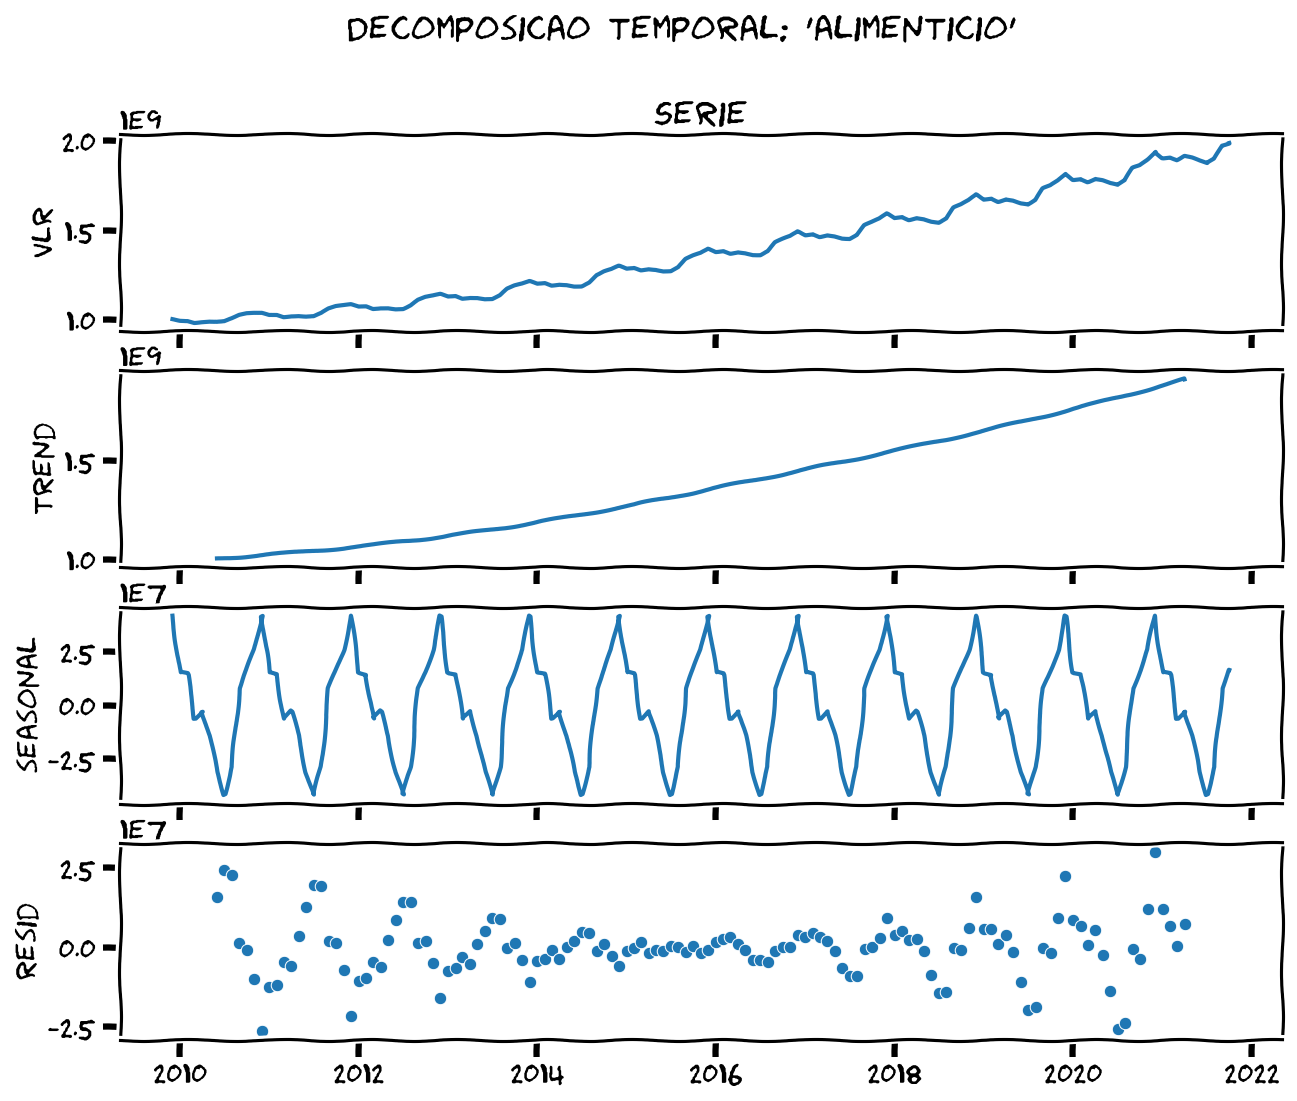

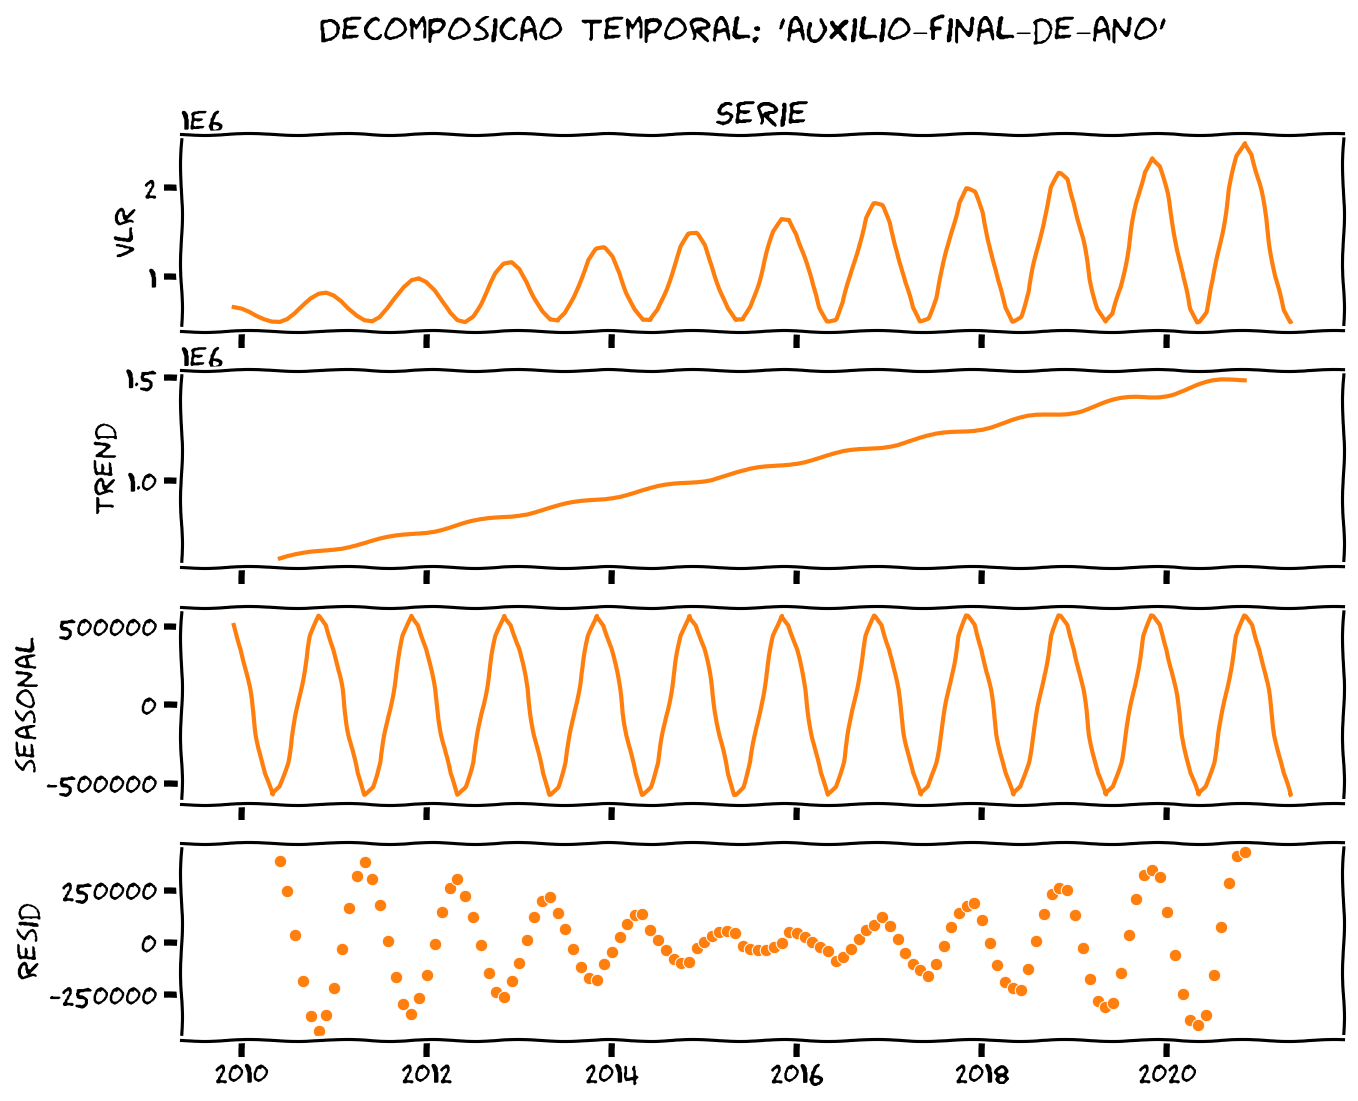

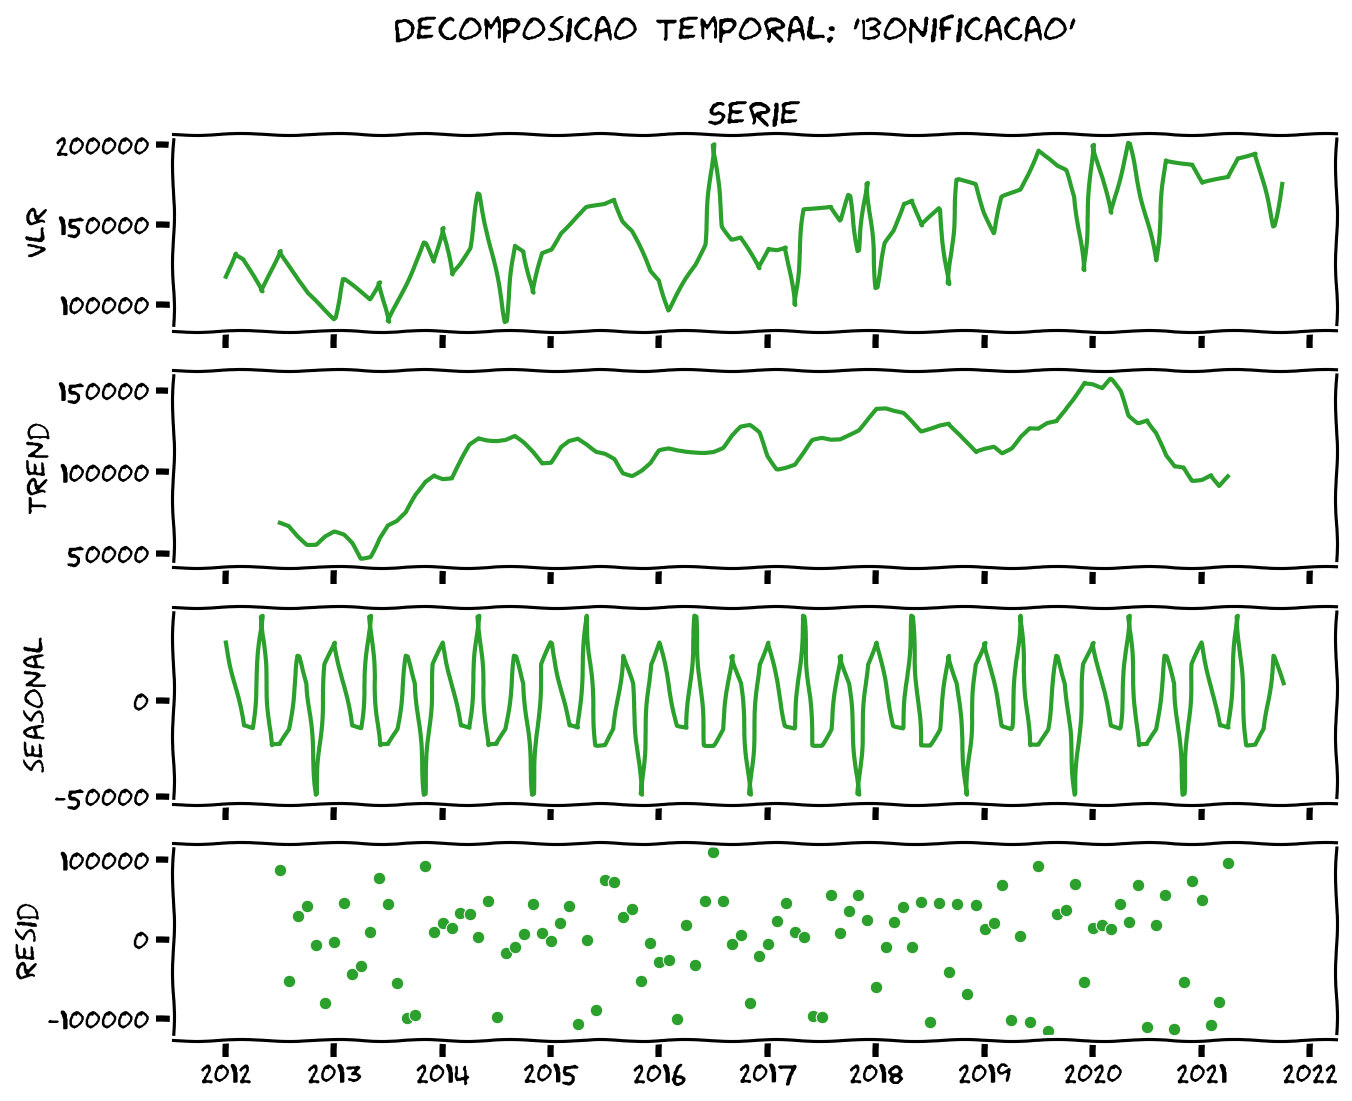

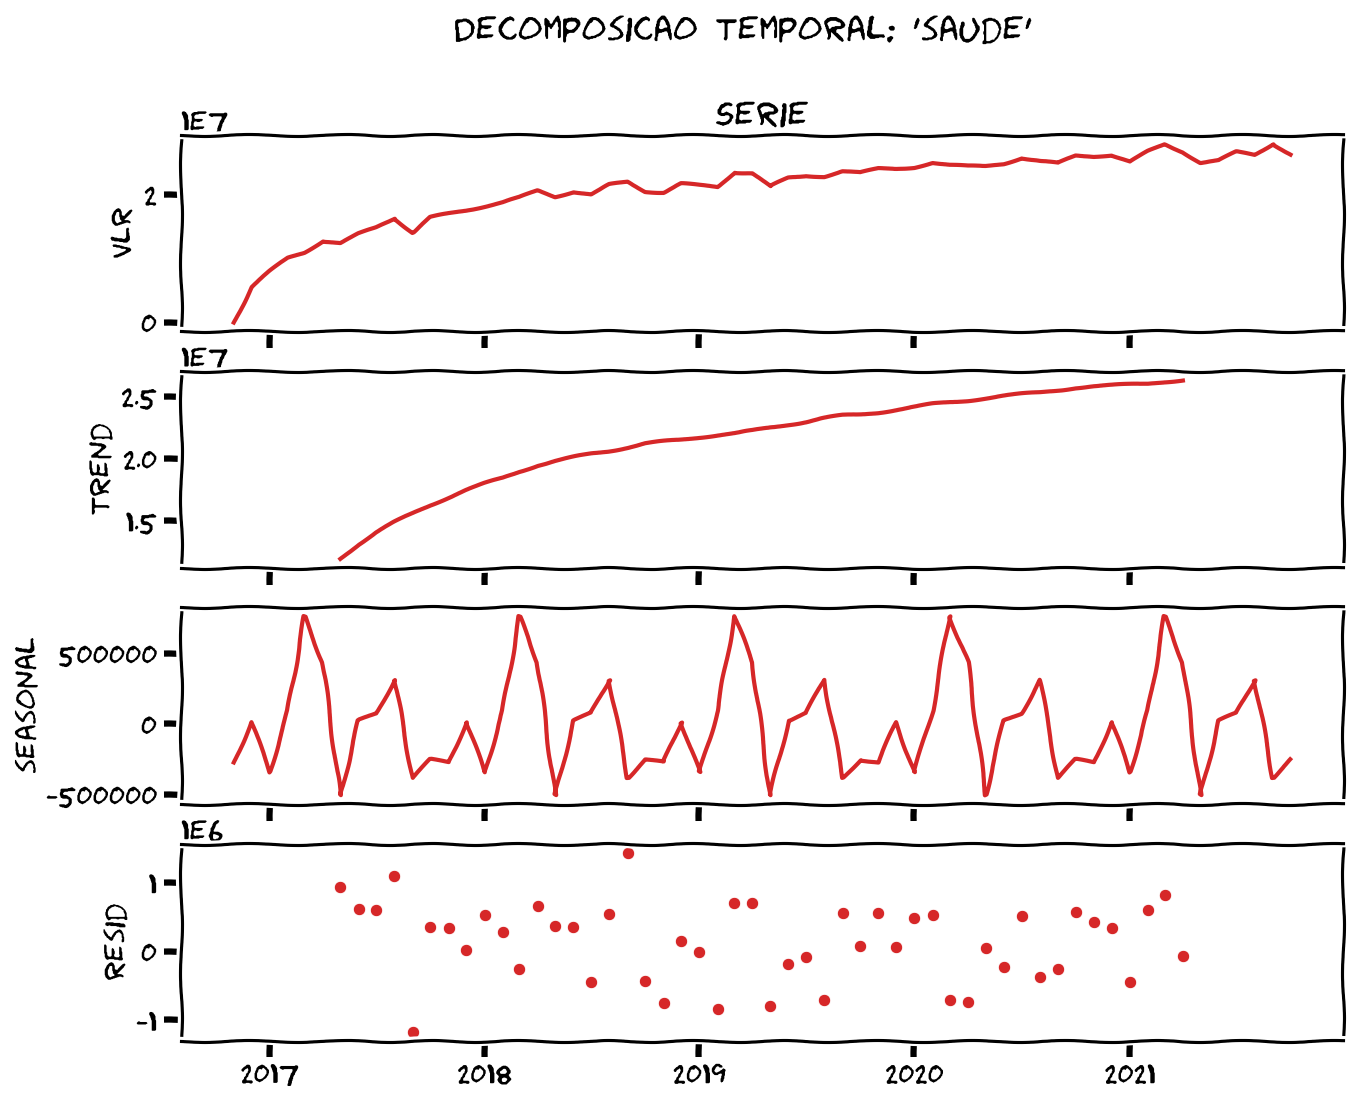

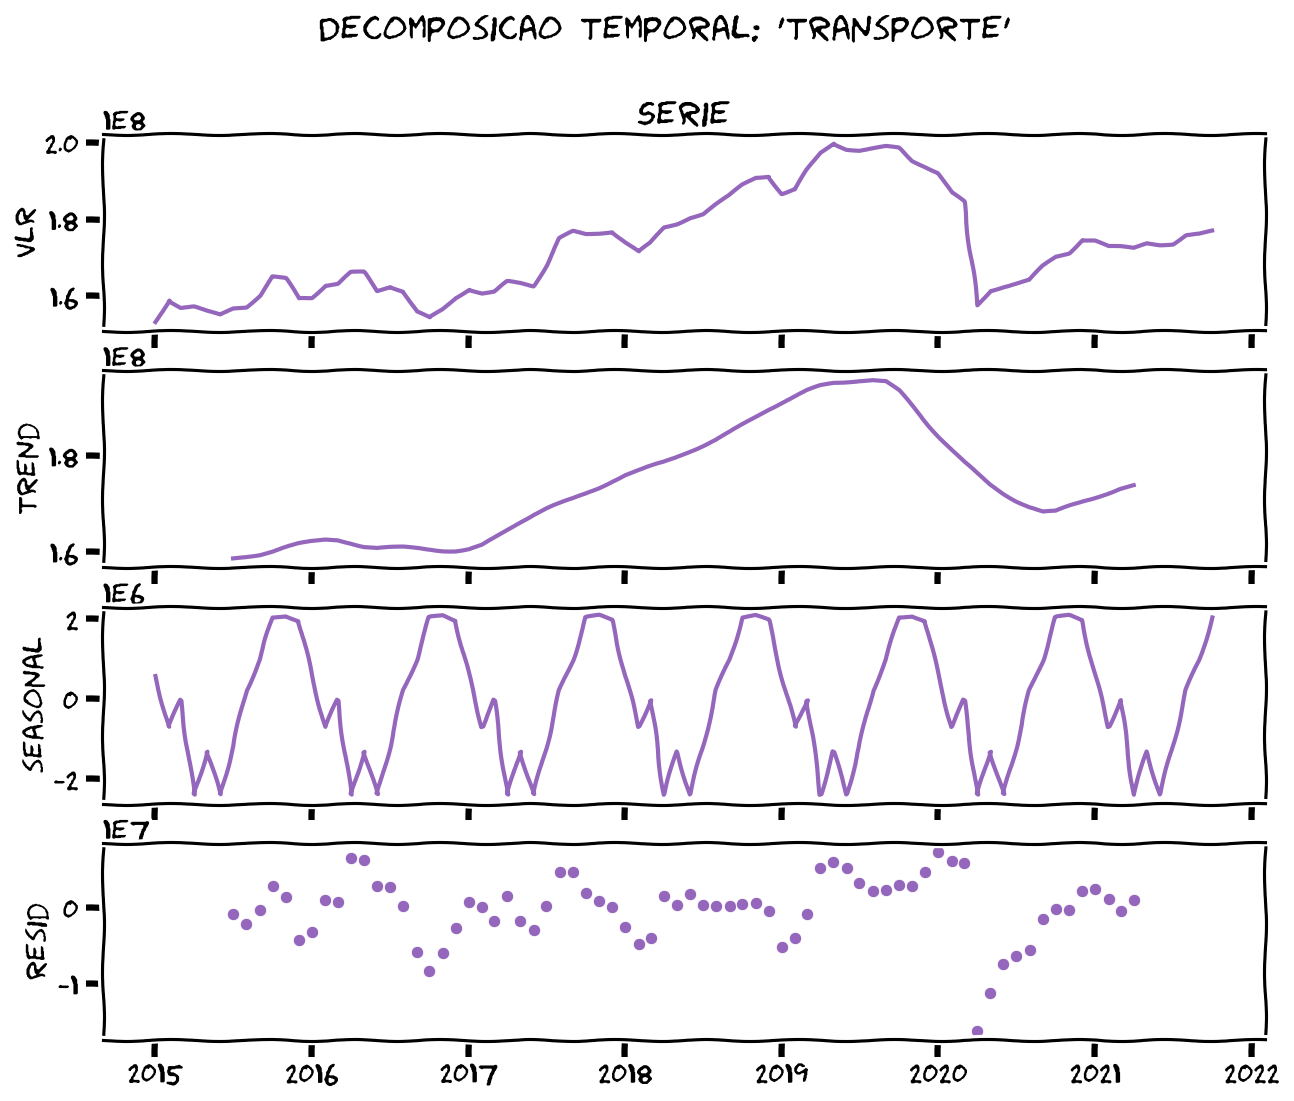

In [39]:
with plt.xkcd():
    n_produtos = len(decomps.keys())
    palette = sns.color_palette(None, n_produtos)

    for i, (produto, decomp) in enumerate(decomps.items()):
        fig, axs = plt.subplots(nrows = 4, figsize = (10, 8), sharex = True)
        ts_filtro = ts.loc[ts.produto == produto, 'vlr']

        c = palette[i]
        
        sns.lineplot(data = ts_filtro, ax = axs[0], color = c)
        axs[0].set_title('Serie')

        sns.lineplot(data = decomp.trend, ax = axs[1], color = c)

        sns.lineplot(data = decomp.seasonal, ax = axs[2], color = c)

        sns.scatterplot(data = decomp.resid, ax = axs[3], color = c)
        
        fig.suptitle(f"Decomposicao temporal: '{produto}'")
        plt.show()

In [45]:
produto


'transporte'

In [46]:
ts_filtro = ts.loc[ts.produto == produto, 'vlr']

In [47]:
ts_filtro

date
2015-01-01    1.532707e+08
2015-02-01    1.590025e+08
2015-03-01    1.570495e+08
2015-04-01    1.572236e+08
2015-05-01    1.559886e+08
                  ...     
2021-06-01    1.735395e+08
2021-07-01    1.737046e+08
2021-08-01    1.759447e+08
2021-09-01    1.761901e+08
2021-10-01    1.768986e+08
Name: vlr, Length: 82, dtype: float64